# Receiving Weighted Opportunity Rating

```
Formula: (1.5 * share of team targets) + (0.7 * share of team yards)
```

In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATABASE = "../database.db"
con = duckdb.connect(DATABASE, read_only=True)
df = con.execute("""
SELECT
    season,
    week,
    category,
    player_id,
    player_name,
    position,
    team,
    ppr_scoring_fantasy_points,
    receiving_targets,
    receiving_yards
FROM player_week_data
""").fetchdf()

In [3]:
df.head()

,season,week,category,player_id,player_name,position,team,ppr_scoring_fantasy_points,receiving_targets,receiving_yards
0,2021,1,stat,1034,Brandon Bolden,RB,NE,0.5,0.0,0.0
1,2021,1,stat,1379,Kyle Juszczyk,RB,SF,1.7,1.0,7.0
2,2021,1,stat,1386,Giovani Bernard,RB,TB,3.2,3.0,12.0
3,2021,1,stat,1387,Rex Burkhead,RB,HOU,1.6,2.0,6.0
4,2021,1,stat,1408,Le'Veon Bell,RB,BAL,0.0,0.0,0.0


In [4]:
df_totals = (
    df
        .groupby(["category", "season", "week", "team"])
        [["receiving_targets", "receiving_yards"]].sum()
        .reset_index()
        .rename(columns={"receiving_targets": "team_receiving_targets", "receiving_yards": "team_receiving_yards"})
)
df_totals.head()

,category,season,week,team,team_receiving_targets,team_receiving_yards
0,proj,2021,1,ARI,44.9,339.58
1,proj,2021,1,ATL,39.4,326.24
2,proj,2021,1,BAL,33.4,275.02
3,proj,2021,1,BUF,36.9,318.31
4,proj,2021,1,CAR,35.1,299.94


In [5]:
join_cols = ["category", "season", "week", "team"]
meta_cols = ["player_id", "player_name", "position"]
metric_cols = ["ppr_scoring_fantasy_points", "receiving_targets", "receiving_yards"]
df_wopr = (
    df
        [join_cols + meta_cols + metric_cols]
        .set_index(join_cols)
        .join(df_totals.set_index(join_cols), how="left")
        .reset_index()
)
df_wopr["share_receiving_targets"] = df_wopr["receiving_targets"] / df_wopr["team_receiving_targets"]
df_wopr["share_receiving_yards"] = df_wopr["receiving_yards"] / df_wopr["team_receiving_yards"]
ser_wopr = (1.5 * df_wopr["share_receiving_targets"]) + (0.7 * df_wopr["share_receiving_yards"])
df_wopr["receiving_weighted_opportunity_rating"] = ser_wopr

In [6]:
df_wopr.query("category == 'stat' and receiving_weighted_opportunity_rating > 0").head(20)

,category,season,week,team,player_id,player_name,position,ppr_scoring_fantasy_points,receiving_targets,receiving_yards,team_receiving_targets,team_receiving_yards,share_receiving_targets,share_receiving_yards,receiving_weighted_opportunity_rating
14051,stat,2021,1,ARI,5000,Chase Edmonds,RB,14.6,4.0,43.0,32.0,289.0,0.125000,0.148789,0.291652
14054,stat,2021,1,ARI,1426,DeAndre Hopkins,WR,26.3,8.0,83.0,32.0,289.0,0.250000,0.287197,0.576038
14056,stat,2021,1,ARI,4950,Christian Kirk,WR,24.0,5.0,70.0,32.0,289.0,0.156250,0.242215,0.403925
14061,stat,2021,1,ARI,7601,Rondale Moore,WR,10.8,5.0,68.0,32.0,289.0,0.156250,0.235294,0.399081
14062,stat,2021,1,ARI,830,A.J. Green,WR,4.5,6.0,25.0,32.0,289.0,0.187500,0.086505,0.341804
14063,stat,2021,1,ARI,1619,Demetrius Harris,TE,0.0,3.0,0.0,32.0,289.0,0.093750,0.000000,0.140625
14064,stat,2021,1,ARI,2360,Maxx Williams,TE,0.0,1.0,0.0,32.0,289.0,0.031250,0.000000,0.046875
14073,stat,2021,1,ATL,1535,Cordarrelle Patterson,RB,8.7,2.0,13.0,33.0,164.0,0.060606,0.079268,0.146397
14074,stat,2021,1,ATL,2073,Keith Smith,RB,6.1,3.0,18.0,33.0,164.0,0.090909,0.109756,0.213193
14075,stat,2021,1,ATL,2431,Mike Davis,RB,10.2,6.0,23.0,33.0,164.0,0.181818,0.140244,0.370898


In [7]:
df_season_stats = (
    df
        .groupby(["player_id", "position", "category", "season"])
        [["ppr_scoring_fantasy_points", "receiving_targets"]].sum()
        .reset_index()
        .rename(columns={
            "ppr_scoring_fantasy_points": "season_ppr_fantasy_points",
            "receiving_targets": "season_receiving_targets"
        })
)
df_top_wr = (
    df_season_stats
        .query("category == 'stat' and season == 2022")
        .sort_values(by=["season_receiving_targets"], ascending=[False])
        .head(5)
)

In [8]:
join_cols = ["player_id", "season"]
df_top_wr_by_week = (
    df_top_wr
        .drop(columns=["position", "category"])
        .set_index(join_cols)
        .join(df_wopr.set_index(join_cols), how="inner")
        .reset_index()
)
df_top_wr_by_week.head()

,player_id,season,season_ppr_fantasy_points,season_receiving_targets,category,week,team,player_name,position,ppr_scoring_fantasy_points,receiving_targets,receiving_yards,team_receiving_targets,team_receiving_yards,share_receiving_targets,share_receiving_yards,receiving_weighted_opportunity_rating
0,2133,2022,323.2,171.0,proj,1,LV,Davante Adams,WR,17.06,9.4,77.35,38.10,288.26,0.246719,0.268334,0.557913
1,2133,2022,323.2,171.0,proj,2,LV,Davante Adams,WR,19.40,9.9,87.91,33.60,291.73,0.294643,0.301340,0.652902
2,2133,2022,323.2,171.0,proj,3,LV,Davante Adams,WR,19.56,10.2,86.96,34.60,274.68,0.294798,0.316587,0.663807
3,2133,2022,323.2,171.0,proj,4,LV,Davante Adams,WR,16.93,8.8,76.69,32.80,259.96,0.268293,0.295007,0.608944
4,2133,2022,323.2,171.0,proj,5,LV,Davante Adams,WR,17.67,10.2,76.00,35.45,249.92,0.287729,0.304097,0.644462


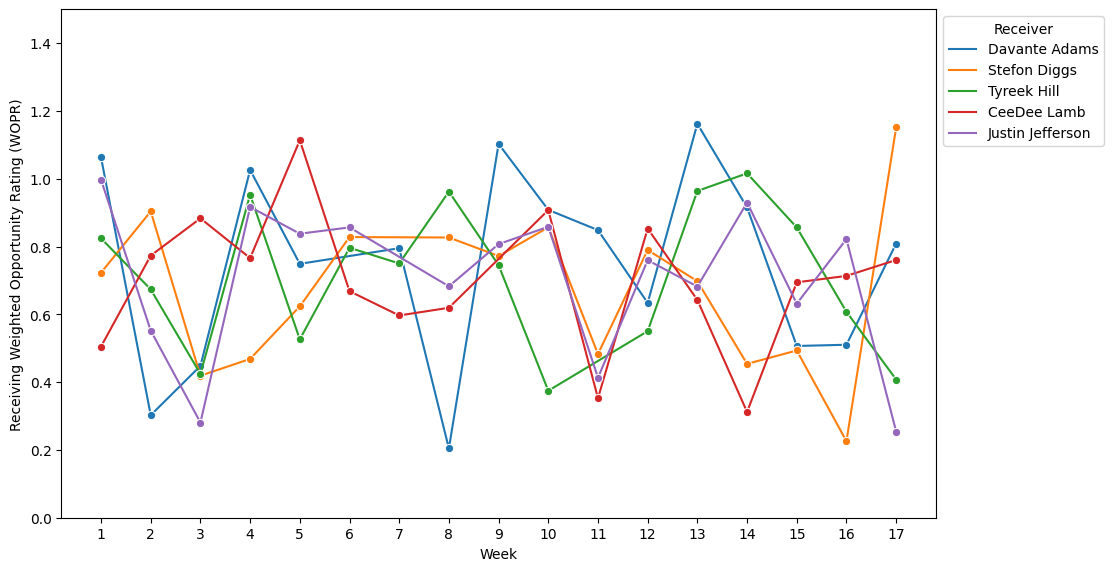

In [9]:
df_top_wr_by_week_stat = df_top_wr_by_week.query("category == 'stat'")
sns.lineplot(data=df_top_wr_by_week_stat, x="week", y="receiving_weighted_opportunity_rating", hue="player_name", marker="o")
plt.xticks(range(1, 18))
plt.ylim(0, 1.5)
plt.xlabel("Week")
plt.ylabel("Receiving Weighted Opportunity Rating (WOPR)")
plt.legend(title="Receiver", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.gcf().set_size_inches(12, 6)
plt.show()

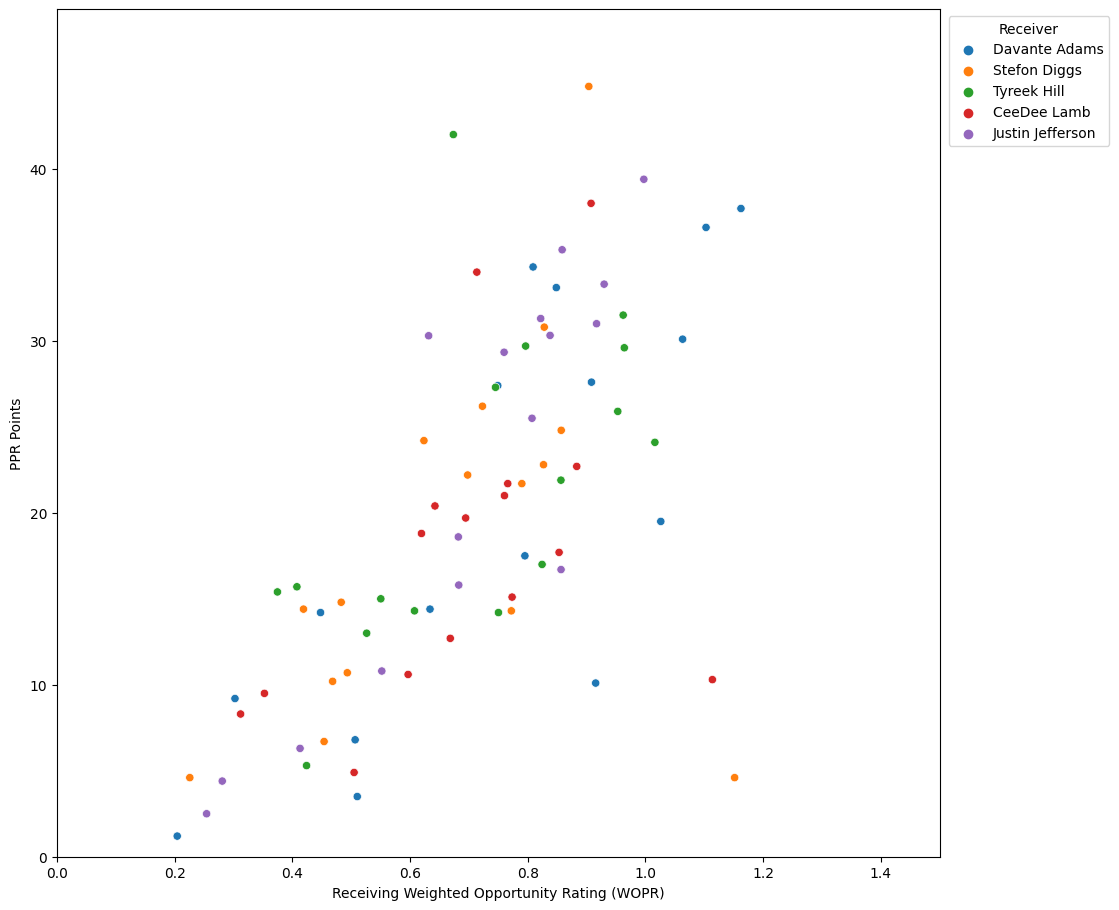

In [10]:
sns.scatterplot(data=df_top_wr_by_week_stat, x="receiving_weighted_opportunity_rating", y="ppr_scoring_fantasy_points", hue="player_name")
plt.xlim(0, 1.5)
plt.ylim(0, df_top_wr_by_week_stat["ppr_scoring_fantasy_points"].max() * 1.1)
plt.xlabel("Receiving Weighted Opportunity Rating (WOPR)")
plt.ylabel("PPR Points")
plt.legend(title="Receiver", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.gcf().set_size_inches(12, 10)
plt.show()